In [2]:
import warnings

warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import scipy.sparse as sparse
import seaborn as sns

sc.logging.print_header()
# sc.logging.print_versions()
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.settings.verbosity = 3  # errors (0), warnings (1), info (2), hints (3)

sns.set_style("white")

np.random.seed(0)

scanpy==1.9.8 anndata==0.8.0 umap==0.5.6 numpy==1.23.0 scipy==1.9.3 pandas==1.3.5 scikit-learn==1.1.3 statsmodels==0.14.1 igraph==0.10.4 louvain==0.8.2 pynndescent==0.5.13


In [3]:
adata = sc.read_h5ad('D:/st_projects/Banksy_py/data/osmFISH/osmFISH_cortex.h5ad')
adata.X = sparse.csr_matrix(adata.X)
# adata = adata[adata.obs['Region']!='Excluded']
adata

AnnData object with n_obs × n_vars = 5328 × 33
    obs: 'ClusterName', 'ClusterID', 'Region'
    uns: 'ClusterName_colors'
    obsm: 'spatial'

In [4]:
# banksy preprocess
from sklearn.neighbors import NearestNeighbors

visualize_weights = True
# KNN里邻居的数量
num_neighbours = 8
sigmas = (-1, )

nbrs = NearestNeighbors(algorithm='ball_tree').fit(adata.obsm['spatial'])
distances, indices = nbrs.kneighbors(n_neighbors=num_neighbours)
median_cell_distance = np.median(distances)
print(f"\nMedian distance to closest cell = {median_cell_distance}")
distances.shape, indices.shape


Median distance to closest cell = 366.00855127543286


((5328, 8), (5328, 8))

Maximum weight: 0.125



(-1194.779296875, 25090.365234375, -2414.51171875, 50704.74609375)

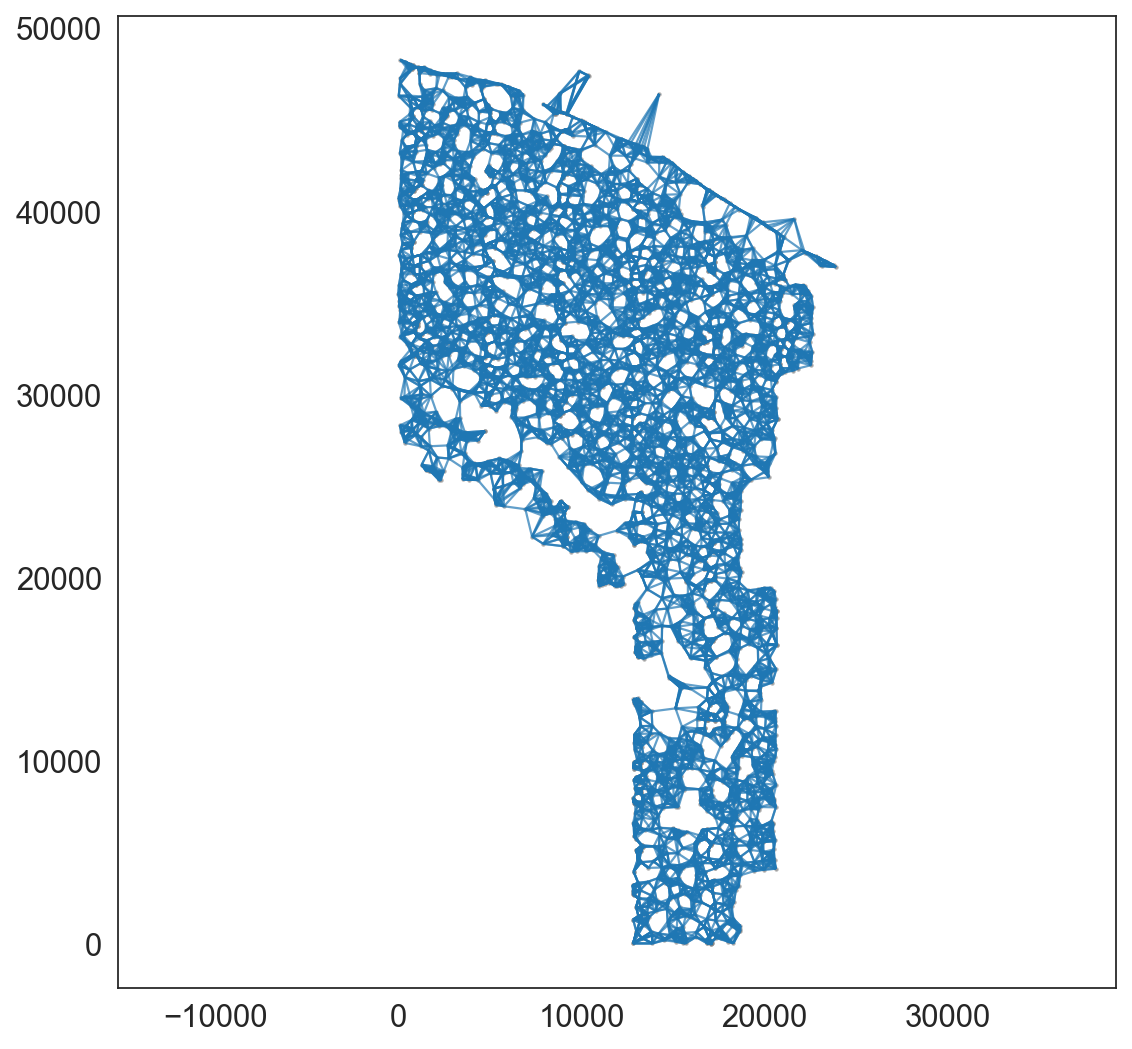

In [5]:
from uti1l import generate_spatial_weights_fixed_nbrs, plot_graph_weights

weights_graph, distance_graph = generate_spatial_weights_fixed_nbrs(adata.obsm['spatial'], num_neighbours=num_neighbours, decay_type='uniform', nbr_object=nbrs, verbose=False)
position = adata.obsm['spatial'].copy()
plot_graph_weights(position, sparse.csr_matrix(np.nan_to_num(weights_graph.A)), max_weight=1, markersize=1, figsize=(8, 8))
ax = plt.gca()
ax.axis('equal')

In [6]:
from uti1l import weighted_concatenate, zscore, matrix_to_adata

gene_list = adata.var.index

nbrhood_contribution = 0.8

neighbour_agg_matrix = weights_graph @ adata.X

if sparse.issparse(adata.X):
    concatenated = sparse.hstack((adata.X, neighbour_agg_matrix), )
else:
    concatenated = np.concatenate((adata.X, neighbour_agg_matrix), axis=1,)

matrix = weighted_concatenate(zscore(adata.X, axis=0), zscore(neighbour_agg_matrix, axis=0), nbrhood_contribution)


if sparse.issparse(matrix):
    st_dev_pergene = matrix.toarray().std(axis=0)
else:
    st_dev_pergene = matrix.std(axis=0)

enhanced_data = matrix_to_adata(matrix, adata)
display(enhanced_data)

num_nbrs: 33


AnnData object with n_obs × n_vars = 5328 × 66
    obs: 'ClusterName', 'ClusterID', 'Region'
    var: 'is_nbr'
    uns: 'ClusterName_colors'
    obsm: 'spatial'

In [7]:
sc.pp.pca(enhanced_data, n_comps=50)
low_dim_x = enhanced_data.obsm['X_pca']

computing PCA
    with n_comps=50
    finished (0:00:00)


In [8]:
from sklearn.metrics.pairwise import cosine_similarity

n_spot = low_dim_x.shape[0]
n_neighbor = 15
init_W = cosine_similarity(low_dim_x)
cos_init = np.zeros((n_spot, n_spot))
for i in range(n_spot):
    vec = init_W[i, :]
    distance = vec.argsort()[:: -1]
    for t in range(n_neighbor + 1):
        y = distance[t]
        cos_init[i, y] = init_W[i, y]

In [9]:
import numpy as np
dim = 11
def min_max_normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

# 对数据进行 Min-Max 归一化
count_sub = np.apply_along_axis(min_max_normalize, 0, low_dim_x)
# count_sub =expression


In [10]:
import numpy as np


def Ge(n):
    """Creates a Gaussian Exponential matrix.

    Args:
        n: The size of the matrix.

    Returns:
        A n x n matrix with values ranging from 0.1 to 0.2.
    """

    # Define the decay factor
    decay_factor = 0.01

    # Create a n x n matrix and initialize all elements to 0
    mat_Ge = np.zeros((n, n))

    # Fill the diagonal elements with 1
    np.fill_diagonal(mat_Ge, 1)

    # Calculate the distance matrix
    dist_matrix = np.abs(np.outer(np.arange(1, n + 1), np.arange(1, n + 1)) - 1)

    # Calculate the decayed values using the exponential function
    mat_Ge = np.exp(-decay_factor * dist_matrix)

    # Adjust the range to 0.1 to 0.2
    mat_Ge = (mat_Ge - np.min(mat_Ge)) / (np.max(mat_Ge) - np.min(mat_Ge)) * 0.1

    # Ensure diagonal elements are 1
    np.fill_diagonal(mat_Ge, 1)

    return mat_Ge

In [11]:
nan_indices = np.argwhere(np.isnan(weights_graph.toarray()))

print("NaN 值的索引为:")
print(nan_indices)

NaN 值的索引为:
[]


In [12]:
import numpy as np

def svd(mat, k):
    u, s, vt = np.linalg.svd(mat, full_matrices=False)
    return u[:, :k], np.diag(s[:k]), vt[:k, :]


# 对 count_sub 进行奇异值分解
svd_result_x = svd(np.transpose(count_sub), dim)
mat_be = np.abs(svd_result_x[0] @ np.sqrt(svd_result_x[1]))
mat_ge = Ge(dim)
mat_fe = np.abs(np.sqrt(svd_result_x[1]) @ svd_result_x[2])

# 对 temp_adata.obsp['connectivities'] 进行奇异值分解
# svd_result_k = svds(weight_graph, k=dim)



svd_result_k = svd(weights_graph.toarray(), dim)
mat_bs = np.abs(svd_result_k[0] @ np.sqrt(svd_result_k[1]))
mat_gs = Ge(dim)
mat_fs = np.abs(np.sqrt(svd_result_k[1]) @ svd_result_k[2])

In [15]:

from ST_SCSR import  ST_SCSR


max_epoch = 20

result = ST_SCSR(np.transpose(count_sub), mat_be, mat_ge, mat_fe, mat_bs, mat_fs, weights_graph.toarray(), max_epoch,cos_init)

##err1  0 is:  146.97750307663546
##err2  0 is:  32.743690965163744
##err3  0 is:  77.8531097918504
##err4  0 is:  51.20033418022835
##err1  1 is:  79.14512693898601
##err2  1 is:  27.224276302205027
##err3  1 is:  62.65933323036685
##err4  1 is:  31.089066036581336
##err1  2 is:  66.56342638726748
##err2  2 is:  25.956117403438867
##err3  2 is:  54.34604194023794
##err4  2 is:  20.425958196213717
##err1  3 is:  62.31211342103148
##err2  3 is:  25.63638765217996
##err3  3 is:  49.29531417132405
##err4  3 is:  14.304524219792695
##err1  4 is:  60.03875437800119
##err2  4 is:  25.60079793808005
##err3  4 is:  45.707766714543055
##err4  4 is:  10.779480915251645
##err1  5 is:  58.618061794215876
##err2  5 is:  25.62042107024938
##err3  5 is:  43.03922821292161
##err4  5 is:  8.737536878651023
##err1  6 is:  57.616771481012215
##err2  6 is:  25.644592569990646
##err3  6 is:  40.981659490378085
##err4  6 is:  7.527013801217576
##err1  7 is:  56.83678887629603
##err2  7 is:  25.6660502054862

running Leiden clustering
    finished: found 11 clusters and added
    'IDCNMF', the cluster labels (adata.obs, categorical) (0:00:00)
cell_778     2
cell_1409    9
cell_3642    0
cell_1302    9
cell_1285    9
            ..
cell_1424    9
cell_1024    1
cell_1307    9
cell_5665    3
cell_5479    7
Name: IDCNMF, Length: 5328, dtype: category
Categories (11, object): ['0', '1', '2', '3', ..., '7', '8', '9', '10']


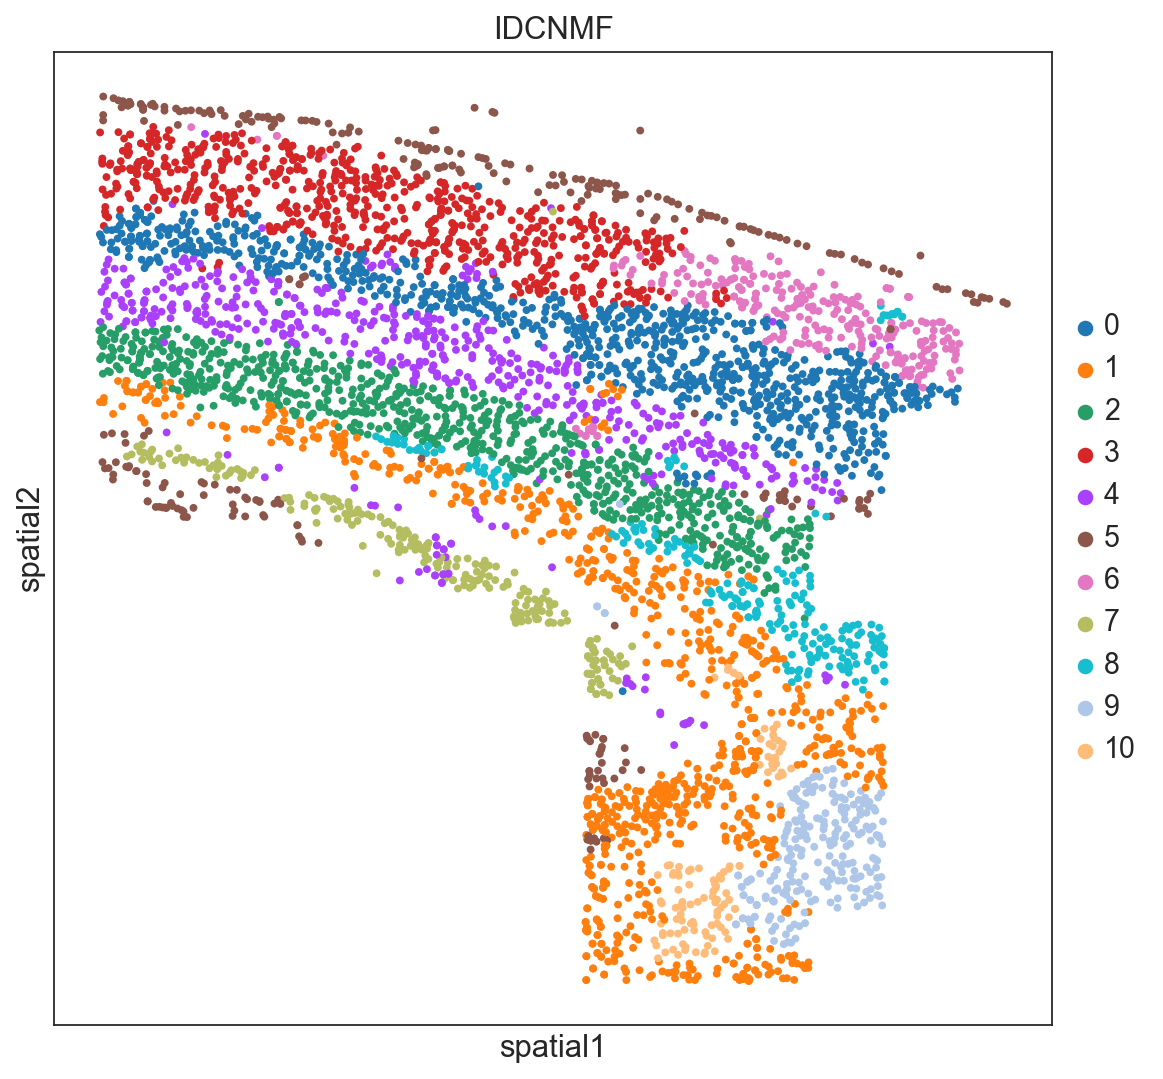

In [16]:
key_added = 'representation'
conns_key = 'representation'
dists_key = 'representation'

enhanced_data.uns[key_added] = {}

representation_dict = enhanced_data.uns[key_added]

representation_dict['connectivities_key'] = conns_key
representation_dict['distances_key'] = dists_key
representation_dict['var_names_use'] = enhanced_data.var_names.to_numpy()

representation_dict['params'] = {}
representation_dict['params']['method'] = 'umap'
enhanced_data.obsp['representation'] = result[2]
sc.tl.leiden(enhanced_data, neighbors_key='representation', resolution=0.35, key_added='IDCNMF')
print(enhanced_data.obs['IDCNMF'])


sc.pl.embedding(enhanced_data, basis='spatial', color=['IDCNMF'], show=True, s=50, title='IDCNMF')


In [18]:
from sklearn.metrics import adjusted_rand_score
# we remove the "Excluded" part
adata_valid = enhanced_data[enhanced_data.obs['Region']!='Excluded']
cur_ari = adjusted_rand_score(adata_valid.obs['IDCNMF'], adata_valid.obs['Region'])
cur_ari

0.6517656385786215